# Build and Deploy Models Leveraging Cancer Gene Expression Data With SageMaker Pipelines and SageMaker Multi-Model Endpoints

This notebook explains:

* How SageMaker Pipelines can be leveraged for building multiple models for gene group.

* How to deploy the those multiple models with SageMaker Multi-Model Endpoints.

* How to query the models, specifying which model type associated with the perticualr gene group to retrieve predictions from.

Before we begin lets verify SageMaker version

In [2]:
import sagemaker
sagemaker.__version__

'2.109.0'

In [3]:
!pip install --upgrade --quiet sagemaker

* Please restart the kernel after the sagemaker update. You can do that by following the options on the menu Kernel->Restart Kernel.
* After restarting execute the from below. Make sure that the version of the sagemaker is updated '>=2.94.0'.

In [4]:
import sagemaker
sagemaker.__version__

'2.109.0'

Then let's import rest of the packages needed.

In [5]:
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sagemaker import get_execution_role

from sagemaker.multidatamodel import MultiDataModel

from sagemaker.pytorch import PyTorch
from sagemaker.pytorch.model import PyTorchModel

from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.functions import Join
from sagemaker.model_metrics import MetricsSource, ModelMetrics
from sagemaker.workflow.functions import Join
from sagemaker.workflow.model_step import ModelStep
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet

from sagemaker.predictor import Predictor

### Read the data 

Data related to the project is available in the data folder. Lets read them and do some explorations.

In [7]:
genomic_data_with_label = pd.read_csv("data/Genomic-data-119patients.csv")
genomic_data_with_label

,Case_ID,LRIG1,HPGD,GDF15,CDH2,POSTN,VCAN,PDGFRA,VCAM1,CD44,...,CD37,VIM,LMO2,EGR2,BGN,COL4A1,COL5A1,COL5A2,SurvivalStatus,PathologicalMstage
0,R01-005,25.438505,2.434890,4.83280,0.000000,14.80001,13.816834,3.791663,3.903575,44.62658,...,1.590920,70.972300,0.00000,0.000000,6.22329,3.268430,9.394910,11.402356,1,0
1,R01-012,23.192370,8.997890,43.86000,2.576560,57.67060,22.893300,6.526380,8.768820,32.54150,...,6.934750,158.976000,3.14894,2.828400,28.85350,22.221980,12.066000,22.500950,0,0
2,R01-013,77.553001,190.529190,7.76279,0.000000,11.79248,26.137328,6.983622,3.591960,152.81587,...,5.048800,115.247000,2.26644,3.317050,5.77029,5.490720,7.749760,3.532330,0,0
3,R01-014,63.164522,21.455770,16.58980,0.000000,20.94288,7.123850,18.156200,2.076650,57.05985,...,4.651934,101.178000,1.32881,1.462162,21.01470,6.839590,2.572220,36.834306,0,0
4,R01-017,82.543949,66.726003,15.27520,1.817656,17.53631,5.260631,7.652980,2.341880,227.60731,...,2.631933,206.286100,1.39513,1.568070,21.19790,16.872651,4.875322,9.060370,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,R01-156,23.141790,8.542742,0.00000,0.684995,119.58400,25.027800,3.129100,2.322870,143.23510,...,4.717760,58.163200,2.62162,0.976505,27.42970,29.316800,35.525100,31.737300,1,0
115,R01-157,6.565445,0.829140,4.94241,0.000000,13.29370,26.306770,3.463640,4.649160,187.18417,...,1.333220,49.906300,1.87628,1.833738,15.31520,17.690250,21.050000,21.977010,0,0
116,R01-158,26.088220,21.237700,4.81202,0.000000,16.14340,10.719810,4.399728,1.937700,126.17160,...,1.286370,57.849300,1.97280,0.659567,7.73836,29.922400,7.174080,9.495350,0,0
117,R01-159,20.813240,3.629507,0.00000,0.000000,19.68492,24.987579,2.346060,9.746220,371.70458,...,22.198750,102.767831,3.39946,2.585660,8.66216,85.256870,6.234190,15.785505,0,0


## Data Cleaning

* Remove Case_ID

In [8]:
genomic_data_with_label.drop(columns=["Case_ID", "PathologicalMstage"], inplace=True)

* Check the Class Balanceness

<AxesSubplot:>

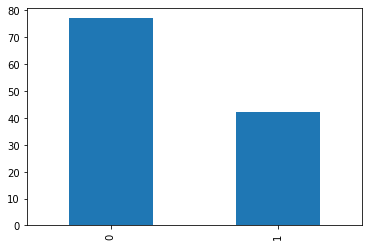

In [9]:
genomic_data_with_label.SurvivalStatus.value_counts().plot.bar()


* Perform min-max scaling

In [10]:
genomic_data = genomic_data_with_label.drop(columns=["SurvivalStatus"])
labels = genomic_data_with_label["SurvivalStatus"]

scaler = MinMaxScaler()
genomic_data[genomic_data.columns] = scaler.fit_transform(genomic_data.to_numpy())
genomic_data                  

,LRIG1,HPGD,GDF15,CDH2,POSTN,VCAN,PDGFRA,VCAM1,CD44,CD48,...,LYL1,SPI1,CD37,VIM,LMO2,EGR2,BGN,COL4A1,COL5A1,COL5A2
0,0.186033,0.011379,0.058076,0.000000,0.044392,0.043852,0.031756,0.077312,0.096727,0.000000,...,0.000000,0.041144,0.071667,0.161186,0.000000,0.000000,0.036592,0.000000,0.037805,0.048075
1,0.168126,0.042051,0.527072,0.014627,0.188186,0.080102,0.058723,0.173671,0.068072,0.208182,...,0.111333,0.264893,0.312394,0.384688,0.132416,0.254566,0.260631,0.098762,0.050754,0.099377
2,0.601524,0.890415,0.093287,0.000000,0.034304,0.093057,0.063232,0.071140,0.353251,0.058441,...,0.061315,0.425206,0.227436,0.273630,0.095306,0.298546,0.032107,0.011580,0.029830,0.011697
3,0.486809,0.100271,0.199362,0.000000,0.064996,0.017122,0.173404,0.041129,0.126207,0.089822,...,0.064753,0.177943,0.209558,0.237899,0.055878,0.131600,0.183027,0.018608,0.004730,0.165631
4,0.641315,0.311836,0.183564,0.010318,0.053570,0.009681,0.069832,0.046382,0.530587,0.075721,...,0.000000,0.109945,0.118562,0.504841,0.058666,0.141132,0.184841,0.070888,0.015895,0.037249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.167722,0.039923,0.000000,0.003889,0.395853,0.088626,0.025222,0.046006,0.330534,0.023121,...,0.196905,0.061541,0.212524,0.128655,0.110241,0.087889,0.246535,0.135732,0.164479,0.142071
115,0.035565,0.003875,0.059394,0.000000,0.039339,0.093734,0.028521,0.092079,0.434741,0.036051,...,0.088405,0.078723,0.060058,0.107685,0.078899,0.165043,0.126602,0.075148,0.094307,0.096955
116,0.191213,0.099252,0.057827,0.000000,0.048898,0.031484,0.037752,0.038377,0.290076,0.026981,...,0.208866,0.090146,0.057948,0.127858,0.082958,0.059363,0.051591,0.138887,0.027039,0.039260
117,0.149158,0.016962,0.000000,0.000000,0.060777,0.088466,0.017501,0.193029,0.872251,0.424727,...,0.343994,0.162622,1.000000,0.241937,0.142950,0.232718,0.060737,0.427221,0.022482,0.068335


### Split the data Train/Test


In [11]:
X_train, X_val, y_train, y_val = train_test_split(genomic_data, labels, test_size = 0.2)


<AxesSubplot:>

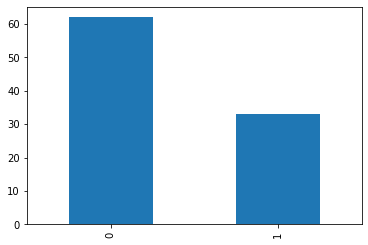

In [12]:
y_train.value_counts().plot.bar()

<AxesSubplot:>

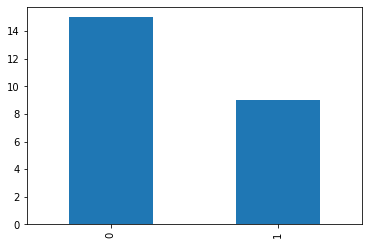

In [13]:
y_val.value_counts().plot.bar()

### Save data

In [14]:
X_train.insert(0, "SurvivalStatus", y_train)
X_train.to_csv("./data/train_data.csv", index = False, header=True)

In [15]:
X_val.insert(0, "SurvivalStatus", y_val)
X_val.to_csv("./data/validation_data.csv", index = False, header=True)

### Prepare for SageMaker Training

In [16]:
role = get_execution_role()
session = sagemaker.Session()
bucket = session.default_bucket()

s3_prefix = "genome-survival-classification/data"

### Upload to S3

In [17]:
input_train = session.upload_data(
        path="./data/train_data.csv", bucket=bucket, key_prefix="{}/train".format(s3_prefix)
    )

input_val = session.upload_data(
        path="./data/validation_data.csv", bucket=bucket, key_prefix="{}/validation".format(s3_prefix)
    )

print("Train data : [{}]".format(input_train))
print("Val data : [{}]".format(input_val))

Train data : [s3://sagemaker-us-west-2-431678540810/genome-survival-classification/data/train/train_data.csv]
Val data : [s3://sagemaker-us-west-2-431678540810/genome-survival-classification/data/validation/validation_data.csv]


## Architecture and Approach 

The architecture for this approach is as follows:


![](images/Architecture.jpeg)

## 1. Create the Multimodel Endpoint 

First we are creating the multi-model endpoint (one time configuration) to serve the models that are going to be delivered by the SageMaker piplines.

In [ ]:
FRAMEWORK_VERSION = "1.12.0"

mme_model_data_location = "s3://{}/{}/mme-models-location".format(bucket, s3_prefix)

endpoint_name = "Genome-Survival-Prediction-MultiModel-Endpoint-{}".format(time.strftime("%H-%M-%S"))

model = PyTorchModel(model_data="./model/model.tar.gz", 
                     source_dir='src', 
                     entry_point='inference.py', 
                     role=role, 
                     framework_version=FRAMEWORK_VERSION,
                     py_version = "py38",
                     sagemaker_session=session)

 
mme = MultiDataModel(
    name = "Genome-Survival-Prediction-MME-Model-{}".format(time.strftime("%H-%M-%S")),
    model_data_prefix = mme_model_data_location,
    model = model,  # passing our model
    sagemaker_session=session,
)

mme_predictor = mme.deploy(
    initial_instance_count=1, 
    instance_type="ml.m5.large", 
    endpoint_name=endpoint_name
)

#### Check for current models (First time it should be empty)

In [ ]:
list(mme.list_models())

## 2. Creating the pipeline 

In [ ]:
pipeline_session = PipelineSession()

from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
    ParameterFloat,
)

input_train_data = ParameterString(
    name="InputTrainData",
    default_value=input_train,
)

input_validation_data = ParameterString(
    name="InputValidationData",
    default_value=input_val,
)

genome_group = ParameterString(
    name="genomeGroup",
    default_value="ALL",
)

training_instance_type = ParameterString(
    name="TrainingInstanceType", 
    default_value="ml.m5.large"
)

mme_model_location = ParameterString(
    name="MMEModelsLocation",
    default_value=mme_model_data_location,
)

from sagemaker.workflow.steps import CacheConfig

cache_config = CacheConfig(enable_caching=True, expire_after="PT1H")


#### Training Step

In [ ]:
pytorch_estimator = PyTorch(
     source_dir="src",           
     entry_point="train.py",
     framework_version = "1.12.0",
     py_version = "py38",
     instance_type= training_instance_type,
     instance_count=1,
     role = role,
     hyperparameters = {
         "genome-group" : genome_group
     },
    sagemaker_session = pipeline_session
)

#pytorch_estimator.fit({"train_data" : input_train, "val_data": input_val})

In [ ]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep

step_train = TrainingStep(
    name="Genome-Survival-Prediction-Training",
    estimator=pytorch_estimator,
    inputs={
        "train_data": TrainingInput(
            s3_data=input_train_data,
            content_type="text/csv",
        ),
         "val_data": TrainingInput(
            s3_data=input_validation_data,
            content_type="text/csv",
        )
    },
    cache_config=cache_config
)

#### Model evaluation Step

In [ ]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.properties import PropertyFile
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

framework_version = "0.23-1"

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type="ml.m5.large",
    instance_count=1,
    base_job_name="Genome-Survival-Prediction-Eval",
    role=role,
    env = {
        "genomeGroup" : genome_group
    },
    sagemaker_session = pipeline_session
)

In [ ]:
evaluation_report = PropertyFile(
    name="EvaluationReport", output_name="evaluation", path="evaluation.json"
)

step_eval = ProcessingStep(
    name="Genome-Survival-Prediction-Eval",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=input_validation_data,
            destination="/opt/ml/processing/test",
        ),
        ProcessingInput(
            source="./src",
            destination="/opt/ml/processing/code",
        )
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation")
    ],
    code="src/evaluation.py",
    property_files=[evaluation_report],
)

In [ ]:
#%run -i src/evaluation.py
# import os
# dirs = os.listdir("./")

# # This would print all the files and directories
# for file in dirs:
#     print(file)

In [ ]:
step_fail = FailStep(
    name="Genome-Survival-Prediction-Fail",
    error_message="Execution failed due to Obective Metric was not met",
)

#### Define a Register Model Step to Create a Model Package


In [ ]:
model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json",
    )
)

model = PyTorchModel(
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    role=role,
    entry_point="inference.py",
    source_dir = "src",
    framework_version = "1.12.0",
    py_version = "py38",
    sagemaker_session=PipelineSession()
)

# in addition, we might also want to register a model to SageMaker Model Registry
register_model_step_args = model.register(
    content_types=["application/json"],
    response_types=["application/json"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name='Genome-Survival-Prediction-Model-Package-Group'
)

step_model_registration = ModelStep(
   name="Genome-Survival-Prediction-Model-Registration",
   step_args=register_model_step_args,
)



#### Define MME Deployment Step


In [ ]:
sklearn_processor_for_mme_deployment = SKLearnProcessor(
    framework_version=framework_version,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    base_job_name="Genome-Survival-Prediction-Deployment",
    role=role,
    env = {
        "modelPackageArn" : step_model_registration.steps[1].properties.ModelPackageArn,
        "mmeModelLocation" : mme_model_location,
        "genomeGroup" : genome_group
    }
)

step_mme_deployment = ProcessingStep(
    name="Genome-Survival-Prediction-MME-Deployment",
    processor=sklearn_processor_for_mme_deployment,
    inputs=[
        
    ],
    outputs=[
        ProcessingOutput(output_name="mme_model_location", source="/opt/ml/processing/model/mme")
    ],
    code="src/mme_deployment.py"
)

### Condition Step

In [ ]:
cond_lte = ConditionLessThanOrEqualTo(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="metrics.test_accuracy.value",
    ),
    right=0.4
)

step_cond = ConditionStep(
    name="Genome-Survival-Prediction-Condition",
    conditions=[cond_lte],
    if_steps=[step_fail],
    else_steps=[step_model_registration, step_mme_deployment],
)

### Create the pipeline using all the steps defined above

In [ ]:
from sagemaker.workflow.pipeline import Pipeline

pipeline_name = f"Genome-Survival-Prediction-Pipeline"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        input_train_data,
        input_validation_data,
        training_instance_type,
        genome_group,
        mme_model_location
    ],
    steps=[step_train, step_eval, step_cond]
)

In [ ]:
import json

definition = json.loads(pipeline.definition())
definition

In [ ]:
pipeline.upsert(role_arn=role)

### Start the pipeline with all the Gene groups.

In [ ]:
execution = pipeline.start({
        "genomeGroup" : "ALL"
    }
)

### Pipeline Operations: Examining and Waiting for Pipeline Execution

* Describe the pipeline execution

In [ ]:
execution.describe()

* Wait for the execution to complete.


In [ ]:
execution.wait()

### Verify how many models deploye on MME

In [ ]:
list(mme.list_models())

* We can see there is model suffixed with 'ALL' already in the MME location. Let's do some predictions with the test dataset. 

### Predict with trained models using test data


In [ ]:
predictor = Predictor(endpoint_name = endpoint_name)

predictor.serializer = sagemaker.serializers.JSONSerializer()
predictor.deserializer = sagemaker.deserializers.CSVDeserializer()

In [ ]:
payload = {
    "inputs" : X_val.iloc[:, 1:].values
}

predictor.predict(payload, target_model="/model-ALL.tar.gz")

### Next lets start training model with the "metagene_19" Gene group

In [ ]:
execution = pipeline.start(
    parameters=dict(
        genomeGroup="metagene_19"
    )
)

In [ ]:
execution.wait()

### Verify how many models deploye on MME

In [ ]:
list(mme.list_models())

* We can see there is a new model suffixed with 'metagene_19' in the MME location. Let's do some predictions with the test dataset. 

In [ ]:
payload = {
    "inputs" : X_val[['LRIG1', 'HPGD', 'GDF15']].iloc[0:5, :].values
}
payload

In [ ]:
predictor.predict(payload, target_model="/model-metagene_19.tar.gz")

## Clean up

In [ ]:
#predictor.delete_endpoint()